In [7]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from tqdm import tqdm

In [8]:
data_dir = Path("M:/neuro2voc/task-5/tf-idf-data-labels")
dfs = []
for i in range(3):
    file_path = data_dir / f"tf-idf-{i}.csv"
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,label
0,0.000000,0.110599,0.000000,0.038573,0.056340,0.000000,0.131188,0.629779,0.169070,0.000000,...,0.059984,0.052617,0.076334,0.000000,0.051810,0.0,0.000000,0.000000,0.000000,2
1,0.000000,0.156129,0.000000,0.145205,0.000000,0.083727,0.000000,0.049391,0.079557,0.124977,...,0.000000,0.049519,0.000000,0.124369,0.000000,0.0,0.000000,0.000000,0.000000,2
2,0.000000,0.050524,0.000000,0.105725,0.000000,0.121924,0.039953,0.479493,0.347555,0.000000,...,0.054804,0.000000,0.069742,0.080492,0.000000,0.0,0.000000,0.000000,0.137138,2
3,0.000000,0.000000,0.000000,0.080573,0.058842,0.092918,0.045672,0.000000,0.044145,0.000000,...,0.187946,0.054955,0.000000,0.138022,0.000000,0.0,0.000000,0.000000,0.000000,2
4,0.084123,0.068863,0.045069,0.096068,0.023386,0.055394,0.072607,0.000000,0.052635,0.073498,...,0.074697,0.000000,0.031686,0.036570,0.021506,0.0,0.000000,0.046227,0.031153,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.000000,0.000000,0.000000,0.060652,0.185863,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.077368,0.080413,0.0,0.107470,0.000000,0.110151,6
3455,0.019081,0.031976,0.048448,0.228617,0.015230,0.024321,0.044981,0.000000,0.060110,0.000000,...,0.017560,0.014448,0.015071,0.000000,0.118604,0.0,0.052837,0.000000,0.000000,7
3456,0.000000,0.038720,0.039111,0.192578,0.018442,0.103076,0.068084,0.142277,0.116459,0.254312,...,0.085053,0.034991,0.036499,0.061413,0.079788,0.0,0.042654,0.000000,0.043718,3
3457,0.000000,0.038029,0.000000,0.165499,0.036225,0.086774,0.026748,0.174673,0.285952,0.117540,...,0.041767,0.034367,0.071695,0.030159,0.094036,0.0,0.000000,0.068155,0.000000,4


In [14]:
# drop 8
combined_df = combined_df[combined_df['label'] != 8]

# Adjust labels to start from 0
combined_df['label'] = combined_df['label'] - 2

# data
X = combined_df.iloc[:, :75] 
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify unique classes
print("Unique classes in y:", np.unique(y))


Unique classes in y: [0 1 2 3 4 5]


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Cluster Sizes:
Cluster 0: 463 samples
Cluster 1: 245 samples
Cluster 2: 300 samples
Cluster 3: 480 samples
Cluster 4: 702 samples
Cluster 5: 573 samples

Cluster Centers (Top 5 most important words per cluster):

Cluster 0 top words (indices): [14 11 13  3 28]
Corresponding weights: [0.53172089 0.47755859 0.21865844 0.20087981 0.14044386]

Cluster 1 top words (indices): [14 11  7 13  3]
Corresponding weights: [0.4826688  0.4235759  0.34333633 0.18880877 0.16481994]

Cluster 2 top words (indices): [14 11  9 10 13]
Corresponding weights: [0.4830812  0.39035512 0.3595404  0.26862493 0.18490249]

Cluster 3 top words (indices): [14 11 13  3  7]
Corresponding weights: [0.52315675 0.50844581 0.20556548 0.19825955 0.16990726]

Cluster 4 top words (indices): [14 11 13  3 33]
Corresponding weights: [0.55694765 0.51538247 0.20891082 0.19751951 0.08189132]

Cluster 5 top words (indices): [14 11 13 10  3]
Corresponding weights: [0.53269549 0.46481318 0.20947406 0.19264612 0.19110815]

Distance Matr

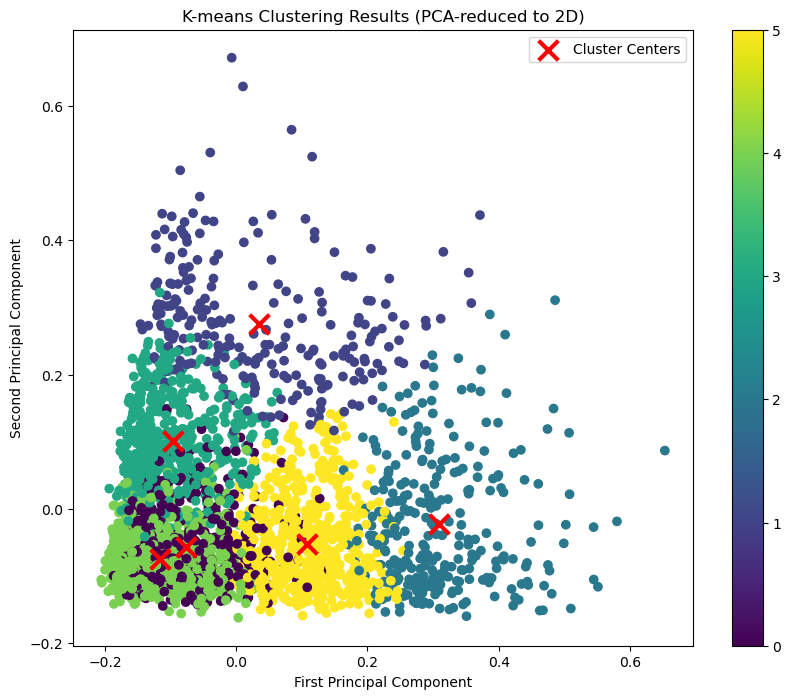

In [13]:
# Perform K-means clustering on X_train
kmeans_train = KMeans(n_clusters=6, random_state=42)
train_clusters = kmeans_train.fit_predict(X_train)

# Get cluster centers and sizes
train_cluster_centers = kmeans_train.cluster_centers_
train_cluster_sizes = np.bincount(train_clusters)

# Print cluster information
print("Cluster Sizes:")
for i, size in enumerate(train_cluster_sizes):
    print(f"Cluster {i}: {size} samples")
    
print("\nCluster Centers (Top 5 most important words per cluster):")
for i, center in enumerate(train_cluster_centers):
    # Get indices of top 5 words in this cluster center
    top_word_indices = np.argsort(center)[-5:][::-1]
    print(f"\nCluster {i} top words (indices):", top_word_indices)
    print(f"Corresponding weights:", center[top_word_indices])

# Calculate intra and inter cluster distances
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Calculate intra-cluster distances
intra_distances = []
for i in range(6):
    cluster_points = X_train[train_clusters == i]
    if len(cluster_points) > 1:
        distances = pdist(cluster_points)
        intra_distances.append(np.mean(distances))
    else:
        intra_distances.append(0)

# Calculate inter-cluster distances
inter_distances = np.zeros((6, 6))
for i in range(6):
    for j in range(i+1, 6):
        dist = np.linalg.norm(train_cluster_centers[i] - train_cluster_centers[j])
        inter_distances[i,j] = dist
        inter_distances[j,i] = dist

# Create a DataFrame for better visualization
import pandas as pd
distance_df = pd.DataFrame(
    inter_distances,
    index=[f'Cluster {i}' for i in range(6)],
    columns=[f'Cluster {i}' for i in range(6)]
)
distance_df['Intra-cluster'] = intra_distances

print("\nDistance Matrix:")
print(distance_df)

# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_clusters, cmap='viridis')
plt.colorbar(scatter)

# Plot cluster centers
centers_2d = pca.transform(train_cluster_centers)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')

plt.title('K-means Clustering Results (PCA-reduced to 2D)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

In [9]:
# Clustering Analysis

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Perform K-means clustering
n_clusters = len(np.unique(y))  # Use same number of clusters as classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Calculate clustering metrics
silhouette_avg = silhouette_score(X, cluster_labels)
db_score = davies_bouldin_score(X, cluster_labels)
ch_score = calinski_harabasz_score(X, cluster_labels)

print("Clustering Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# Calculate inertia (within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"\nInertia (Within-cluster sum of squares): {inertia:.3f}")

# Calculate cluster centers and sizes
cluster_centers = kmeans.cluster_centers_
cluster_sizes = np.bincount(cluster_labels)

print("\nCluster Sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i}: {size} samples")


Clustering Evaluation Metrics:
Silhouette Score: 0.032
Davies-Bouldin Score: 4.085
Calinski-Harabasz Score: 131.649

Inertia (Within-cluster sum of squares): 631.509

Cluster Sizes:
Cluster 0: 902 samples
Cluster 1: 401 samples
Cluster 2: 348 samples
Cluster 3: 688 samples
Cluster 4: 565 samples
Cluster 5: 550 samples


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


# SVM

In [15]:
# Scale the data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Create SVC without pipeline since we scaled manually
svc = SVC(random_state=42)

grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Evaluate on the test set
test_score = grid_search.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_score:.3f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.800
Test set accuracy: 0.802


In [5]:
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']
}

# pipeline
svm_pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))


grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Evaluate on the test set
test_score = grid_search.score(X_test, y_test)
print(f"Test set accuracy: {test_score:.3f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best cross-validation score: 0.800
Test set accuracy: 0.802


# XGBoost

In [16]:
# Define parameter grid for XGBRFClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bynode': [0.6, 0.8, 1.0]
}

# Create XGBRFClassifier
xgb_rf = xgb.XGBRFClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_xgb_rf = grid_search.best_estimator_

# Evaluate on the test set
test_score = best_xgb_rf.score(X_test, y_test)
print("Test set accuracy:", test_score)

# Make predictions on the test set
y_pred = best_xgb_rf.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = best_xgb_rf.feature_importances_
top_features = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

print("\nTop 10 important features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. Feature {feature}: {feature_importance[feature]}")

# Save the best model
best_xgb_rf.save_model('best_xgboost_rf_model.json')
print("\nBest model saved as 'best_xgboost_rf_model.json'")

# Save the feature importances
np.save('best_xgboost_feature_importances.npy', feature_importance)
print("Feature importances saved as 'best_xgboost_feature_importances.npy'")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bynode': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validation score: 0.8204903425321698
Test set accuracy: 0.8205499276410999

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68       105
           1       0.84      0.84      0.84       133
           2       0.85      0.87      0.86       126
           3       0.91      0.87      0.89       130
           4       0.73      0.88      0.80       110
           5       0.76      0.84      0.80        87

    accuracy                           0.82       691
   macro avg       0.82      0.82      0.81       691
weighted avg       0.82      0.82      0.82       691


Confusion Matrix:
[[ 62   2   9   0  30   2]
 [  0 112   2   9   0  10]
 [  3   3 110   2   4   4]
 [  1   4   4 113   1   7]
 [ 11   0   2   0  97   0]
 [  0  1